In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from svhn_utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = svhn(valid=10000, batch_size=32)

Using downloaded and verified file: ./SVHN_data/test_32x32.mat
Using downloaded and verified file: ./SVHN_data/train_32x32.mat
train shape:  (73257, 3, 32, 32)
test shape:  (26032, 3, 32, 32)


Using downloaded and verified file: ./SVHN_data/train_32x32.mat


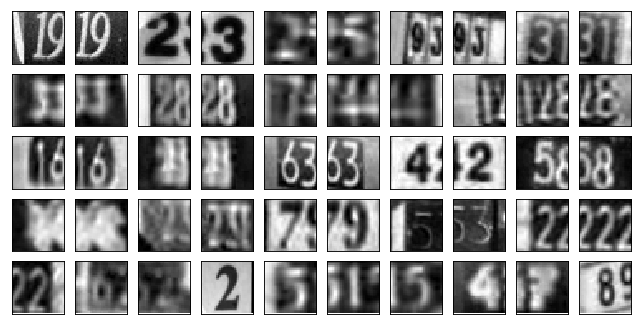

In [3]:
images = svhn_plotdata()
plot_svhn(images, (5, 10))

## Обучение классификатора

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models):
    loss_stats = np.empty((0,4))
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
       
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()                
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = np.array([m._loss.item() for m in models])
            loss_stats = np.vstack([loss_stats, stats_line])          
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = np.array([m._loss.item() for m in models])
        loss_stats = np.vstack([loss_stats, stats_line])
       
    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [6]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [7]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss, correct_pct

In [8]:
epoch_train_loss = []
epoch_test_loss = []
epoch_test_acc = []

In [9]:
for epoch in range(1, 21):
    for model in models:
        model.train()
    train_loss_val = train(epoch, models)
    epoch_train_loss.append(train_loss_val)
    
    for model in models:
        model.eval()
    test_loss_val, test_acc_val = test(models, valid_loader)
    epoch_test_loss.append(test_loss_val)
    epoch_test_acc.append(test_acc_val)
    

Train Epoch: 1 [0/63257 (0%)]	Losses 0: 2.283175 1: 2.305574 2: 2.306559 3: 2.302322
Train Epoch: 1 [6400/63257 (10%)]	Losses 0: 1.939182 1: 2.012639 2: 1.976668 3: 2.089469
Train Epoch: 1 [12800/63257 (20%)]	Losses 0: 1.541806 1: 1.814234 2: 1.655859 3: 1.815348
Train Epoch: 1 [19200/63257 (30%)]	Losses 0: 1.198216 1: 1.372008 2: 1.174235 3: 1.415210
Train Epoch: 1 [25600/63257 (40%)]	Losses 0: 1.636793 1: 1.658110 2: 1.614533 3: 1.641795
Train Epoch: 1 [32000/63257 (51%)]	Losses 0: 1.241719 1: 1.321250 2: 1.265173 3: 1.301972
Train Epoch: 1 [38400/63257 (61%)]	Losses 0: 1.054686 1: 1.275208 2: 1.065179 3: 1.265963
Train Epoch: 1 [44800/63257 (71%)]	Losses 0: 1.017704 1: 1.130971 2: 1.020903 3: 1.108839
Train Epoch: 1 [51200/63257 (81%)]	Losses 0: 0.673073 1: 1.025766 2: 0.698586 3: 1.039743
Train Epoch: 1 [57600/63257 (91%)]	Losses 0: 1.137712 1: 1.033563 2: 1.100100 3: 1.108754
Train Epoch: 1 [49425/63257 (100%)]	Losses 0: 0.846899 1: 1.016523 2: 0.908517 3: 1.009258
Test set:
0: Lo

Train Epoch: 8 [6400/63257 (10%)]	Losses 0: 0.296206 1: 0.428659 2: 0.342221 3: 0.351970
Train Epoch: 8 [12800/63257 (20%)]	Losses 0: 0.687943 1: 0.871280 2: 0.670793 3: 0.945924
Train Epoch: 8 [19200/63257 (30%)]	Losses 0: 0.678774 1: 0.692130 2: 0.695429 3: 0.601126
Train Epoch: 8 [25600/63257 (40%)]	Losses 0: 0.624336 1: 0.486149 2: 0.498465 3: 0.646060
Train Epoch: 8 [32000/63257 (51%)]	Losses 0: 0.950190 1: 1.095742 2: 0.931394 3: 0.895243
Train Epoch: 8 [38400/63257 (61%)]	Losses 0: 0.468429 1: 0.512830 2: 0.389057 3: 0.429223
Train Epoch: 8 [44800/63257 (71%)]	Losses 0: 0.544739 1: 0.855756 2: 0.628666 3: 0.663029
Train Epoch: 8 [51200/63257 (81%)]	Losses 0: 0.426118 1: 0.405923 2: 0.423077 3: 0.600441
Train Epoch: 8 [57600/63257 (91%)]	Losses 0: 0.370831 1: 0.371723 2: 0.314518 3: 0.430372
Train Epoch: 8 [49425/63257 (100%)]	Losses 0: 0.583513 1: 0.845287 2: 0.574403 3: 0.649911
Test set:
0: Loss: 0.6281	Accuracy: 8185/10000 (81%)
1: Loss: 0.6304	Accuracy: 8125/10000 (81%)
2: L

Train Epoch: 15 [6400/63257 (10%)]	Losses 0: 0.462752 1: 0.433141 2: 0.552150 3: 0.521970
Train Epoch: 15 [12800/63257 (20%)]	Losses 0: 0.303451 1: 0.566437 2: 0.311523 3: 0.465925
Train Epoch: 15 [19200/63257 (30%)]	Losses 0: 0.398536 1: 0.445385 2: 0.330068 3: 0.336748
Train Epoch: 15 [25600/63257 (40%)]	Losses 0: 0.403961 1: 0.500757 2: 0.388227 3: 0.410243
Train Epoch: 15 [32000/63257 (51%)]	Losses 0: 0.250176 1: 0.534699 2: 0.288847 3: 0.558994
Train Epoch: 15 [38400/63257 (61%)]	Losses 0: 0.185308 1: 0.236485 2: 0.169147 3: 0.171647
Train Epoch: 15 [44800/63257 (71%)]	Losses 0: 0.309133 1: 0.473174 2: 0.372482 3: 0.478345
Train Epoch: 15 [51200/63257 (81%)]	Losses 0: 0.515056 1: 0.421721 2: 0.504382 3: 0.491827
Train Epoch: 15 [57600/63257 (91%)]	Losses 0: 0.793221 1: 1.057143 2: 0.718503 3: 0.876554
Train Epoch: 15 [49425/63257 (100%)]	Losses 0: 0.226167 1: 0.511464 2: 0.291061 3: 0.485241
Test set:
0: Loss: 0.5939	Accuracy: 8340/10000 (83%)
1: Loss: 0.5703	Accuracy: 8326/10000 

In [10]:
final_train_loss = np.array(epoch_train_loss)
final_test_loss = np.array(epoch_test_loss)
final_test_acc = np.array(epoch_test_acc)

## Вывод результатов

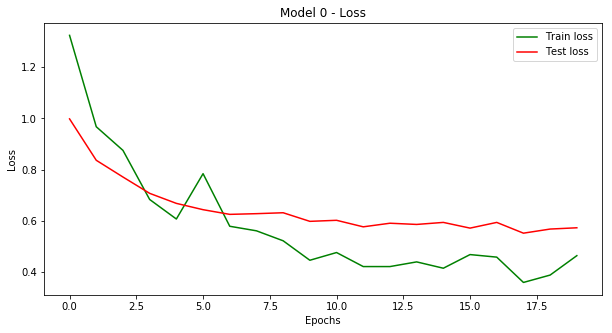

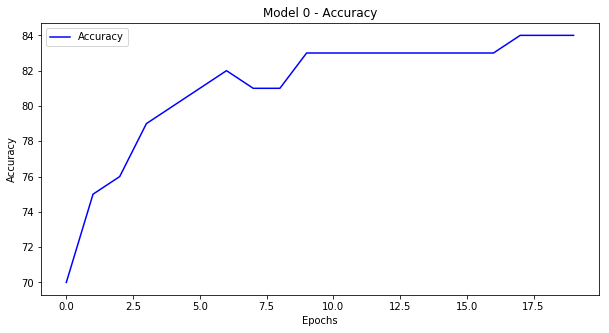

In [11]:
plot_results(0, final_train_loss, final_test_loss, final_test_acc)

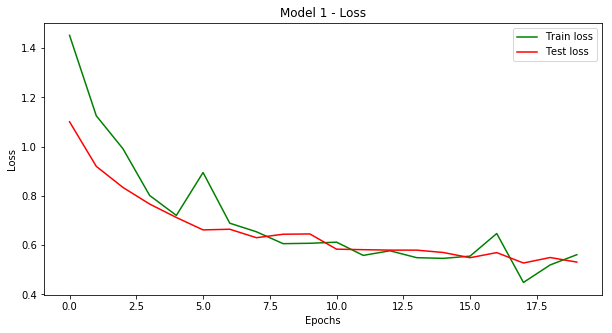

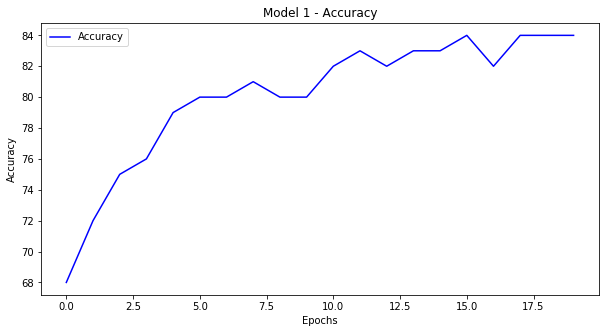

In [12]:
plot_results(1, final_train_loss, final_test_loss, final_test_acc)

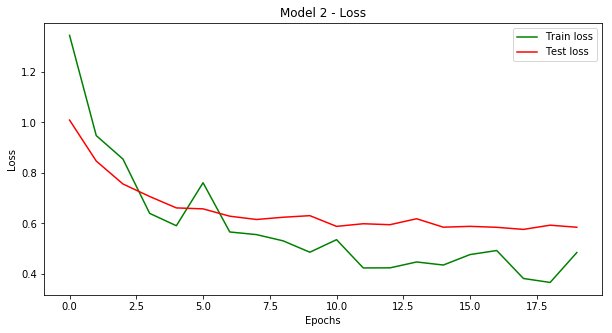

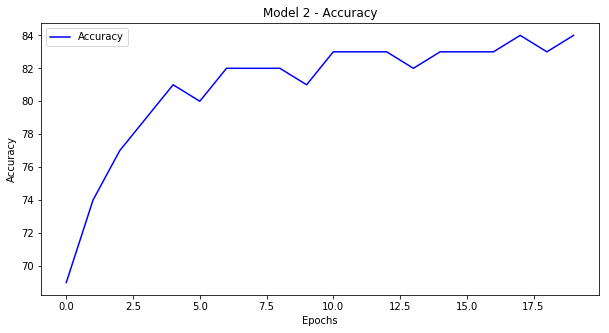

In [13]:
plot_results(2, final_train_loss, final_test_loss, final_test_acc)

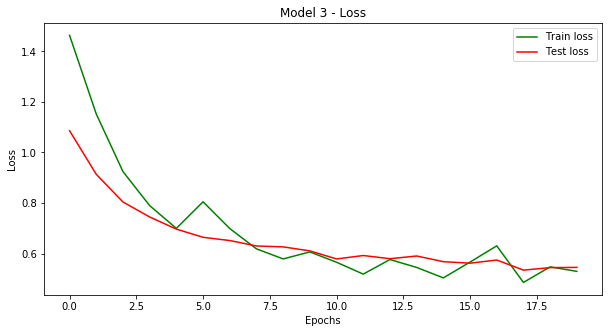

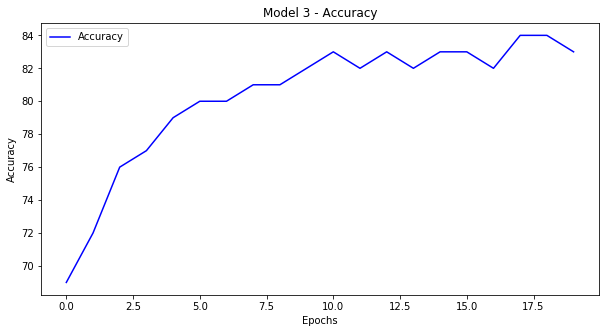

In [14]:
plot_results(3, final_train_loss, final_test_loss, final_test_acc)